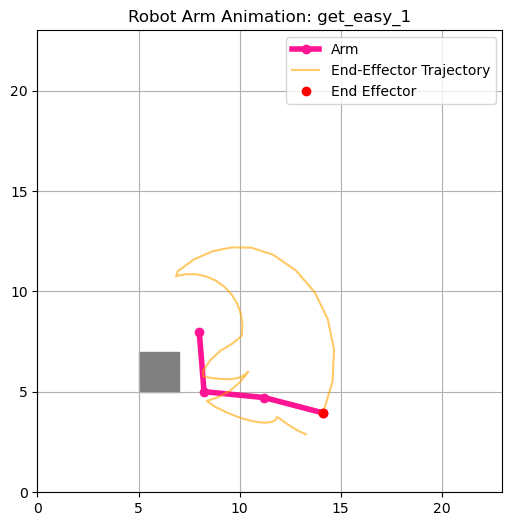

In [1]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon
import ipywidgets as widgets
from IPython.display import clear_output, display
import time
from matplotlib import animation
from scipy.interpolate import interp1d
from IPython.display import HTML

# Import the TestEnvironments class from the uploaded module
from testEnvironments import TestEnvironments

# ---------- LOAD ENVIRONMENTS ----------
test_envs = TestEnvironments()
scene_dict = test_envs.get_all_scenes()

# Transform scenes into usable format
def convert_scene_to_env(name, scene):
    start = scene.get("start", Point(0, 0).buffer(0.8))
    goal = scene.get("goal", Point(0, 0).buffer(0.8))
    obstacles = [geom for key, geom in scene.items() if key not in ["start", "goal"]]
    start_center = start.centroid.coords[0]
    goal_center = goal.centroid.coords[0]
    return {
        "map_bounds": (0, 23, 0, 23),
        "start": start_center,
        "goal": goal_center,
        "obstacles": obstacles
    }

environments = {name: convert_scene_to_env(name, scene) for name, scene in scene_dict.items()}

# ---------- PARAMETERS ----------
samples_per_region = 40
lazy_k_neighbors = 8
num_regions = 4
collision_checks = 0

# ---------- PRM UTILITY FUNCTIONS ----------
def is_collision(p1, p2, obstacles):
    global collision_checks
    collision_checks += 1
    line = LineString([p1, p2])
    return any(line.crosses(obs) or line.within(obs) for obs in obstacles)

def sample_free(bounds, obstacles):
    minx, maxx, miny, maxy = bounds
    while True:
        x, y = random.uniform(minx, maxx), random.uniform(miny, maxy)
        if not any(obs.contains(Point(x, y)) for obs in obstacles):
            return (x, y)

def build_lazy_prm(region_bounds, num_samples, k, obstacles):
    G = nx.Graph()
    nodes = [sample_free(region_bounds, obstacles) for _ in range(num_samples)]
    G.add_nodes_from(nodes)
    for node in nodes:
        distances = sorted(
            ((other, np.linalg.norm(np.subtract(node, other))) for other in nodes if other != node),
            key=lambda x: x[1]
        )[:k]
        for neighbor, dist in distances:
            G.add_edge(node, neighbor, weight=dist)
    return G

def build_visibility_prm(nodes, obstacles):
    G = nx.Graph()
    for node in nodes:
        G.add_node(node)
        for other in G.nodes:
            if other != node and not G.has_edge(node, other):
                if not is_collision(node, other, obstacles):
                    dist = np.linalg.norm(np.subtract(node, other))
                    G.add_edge(node, other, weight=dist)
    return G

def build_hierarchical_visibility_lazy_prm(global_bounds, num_regions, samples_per_region, k, obstacles):
    minx, maxx, miny, maxy = global_bounds
    midx, midy = (minx + maxx) / 2, (miny + maxy) / 2
    regions = [
        (minx, midx, miny, midy),
        (midx, maxx, miny, midy),
        (minx, midx, midy, maxy),
        (midx, maxx, midy, maxy)
    ]
    local_graphs = [build_lazy_prm(region, samples_per_region, k, obstacles) for region in regions]
    all_nodes = [node for g in local_graphs for node in g.nodes]
    global_graph = build_visibility_prm(all_nodes, obstacles)
    for g in local_graphs:
        global_graph.add_edges_from(g.edges(data=True))
    return global_graph

def validate_lazy_path(G, path, obstacles):
    valid = True
    for u, v in zip(path[:-1], path[1:]):
        if is_collision(u, v, obstacles):
            G.remove_edge(u, v)
            valid = False
    return valid

def lazy_shortest_path(G, start, goal, obstacles):
    while True:
        try:
            path = nx.shortest_path(G, source=start, target=goal, weight='weight')
        except nx.NetworkXNoPath:
            return None
        if validate_lazy_path(G, path, obstacles):
            return path

def forward_kinematics(joint_angles, link_lengths, base=(0, 0)):
    x, y = base
    theta = 0
    points = [(x, y)]
    for angle, length in zip(joint_angles, link_lengths):
        theta += angle
        x += length * np.cos(theta)
        y += length * np.sin(theta)
        points.append((x, y))
    return points

def inverse_kinematics_2d(target, link_lengths, base=(0, 0), max_iter=1000, tol=1e-2, restarts=5):
    dof = len(link_lengths)
    for attempt in range(restarts):
        angles = np.random.uniform(-np.pi, np.pi, size=dof)  # random start
        for _ in range(max_iter):
            points = forward_kinematics(angles, link_lengths, base)
            end_effector = np.array(points[-1])
            error = np.linalg.norm(end_effector - target)
            if error < tol:
                return tuple(angles)
            for i in reversed(range(dof)):
                current = np.array(points[i])
                end_effector = np.array(points[-1])
                to_end = end_effector - current
                to_goal = np.array(target) - current
                angle1 = np.arctan2(to_end[1], to_end[0])
                angle2 = np.arctan2(to_goal[1], to_goal[0])
                angles[i] += angle2 - angle1
    return None


def is_robot_collision(joint_angles, link_lengths, obstacles, base=(0, 0)):
    points = forward_kinematics(joint_angles, link_lengths, base)
    for i in range(len(points) - 1):
        seg = LineString([points[i], points[i+1]])
        if any(seg.crosses(obs) or seg.within(obs) for obs in obstacles):
            return True
    return False


def edge_in_collision(config1, config2, link_lengths, obstacles, base=(0, 0), steps=20):
    for alpha in np.linspace(0, 1, steps):
        interp_config = tuple((1 - alpha) * a + alpha * b for a, b in zip(config1, config2))
        if is_robot_collision(interp_config, link_lengths, obstacles, base):
            return True
    return False

def sample_robot_configuration(dof):
    return tuple(random.uniform(-np.pi, np.pi) for _ in range(dof))

def build_robot_arm_prm(dof, num_samples, k, link_lengths, obstacles, base=(0, 0)):
    G = nx.Graph()
    nodes = []
    while len(nodes) < num_samples:
        config = sample_robot_configuration(dof)
        if not is_robot_collision(config, link_lengths, obstacles, base):
            nodes.append(config)
    G.add_nodes_from(nodes)
    for node in nodes:
        distances = sorted(
            ((other, np.linalg.norm(np.subtract(node, other))) for other in nodes if other != node),
            key=lambda x: x[1]
        )[:k]
        for neighbor, dist in distances:
            if not edge_in_collision(node, neighbor, link_lengths, obstacles, base=base):
                G.add_edge(node, neighbor, weight=dist)
    return G

from scipy.interpolate import interp1d
from IPython.display import HTML

def animate_robot_arm_path(path, link_lengths, obstacles, environment_name, base_start=(0,0), base_goal=(0,0)):
    plt.close('all')

    if len(path) < 2:
        print("Path too short to animate.")
        return

    path = np.array(path)
    num_joints = path.shape[1]

    # Compute cumulative distances along joint space path
    dists = np.cumsum([0] + [np.linalg.norm(path[i] - path[i - 1]) for i in range(1, len(path))])
    total_dist = dists[-1]

    # Interpolate 60 frames
    num_frames = 60
    interp_dists = np.linspace(0, total_dist, num_frames)
    interpolators = [interp1d(dists, path[:, j], kind='linear') for j in range(num_joints)]
    interpolated_path = np.column_stack([f(interp_dists) for f in interpolators])

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot obstacles
    for obs in obstacles:
        if isinstance(obs, Polygon):
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')

    ax.set_xlim(0, 23)
    ax.set_ylim(0, 23)
    ax.set_title(f"Robot Arm Animation: {environment_name}")
    ax.grid(True)

    # Arm links + end effector trajectory
    arm_line, = ax.plot([], [], 'o-', lw=4, color='deeppink', label="Arm")
    eff_traj, = ax.plot([], [], '-', color='orange', alpha=0.6, lw=1.5, label="End-Effector Trajectory")
    eff_dot, = ax.plot([], [], 'ro', markersize=6, label="End Effector")

    eff_x, eff_y = [], []

    def init():
        arm_line.set_data([], [])
        eff_traj.set_data([], [])
        eff_dot.set_data([], [])
        return arm_line, eff_traj, eff_dot

    def update(frame):
        config = interpolated_path[frame]
        points = forward_kinematics(config, link_lengths, base_start)
        xs, ys = zip(*points)

        # Update arm
        arm_line.set_data(xs, ys)

        # Update end effector path
        eff_x.append(xs[-1])
        eff_y.append(ys[-1])
        eff_traj.set_data(eff_x, eff_y)
        eff_dot.set_data([xs[-1]], [ys[-1]])

        return arm_line, eff_traj, eff_dot

    ani = animation.FuncAnimation(
        fig, update, frames=num_frames,
        init_func=init, blit=True, interval=1000 / 60, repeat=False
    )
    ax.legend()
    display(HTML(ani.to_jshtml()))



# ---------- MAIN EXECUTION FUNCTION ----------
def plot_prm(G, obstacles, start, goal, path=None, environment_name=""):
    plt.figure(figsize=(6, 6))
    
    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray')
    
    # Plot PRM graph
    for u, v in G.edges():
        x_vals = [u[0], v[0]]
        y_vals = [u[1], v[1]]
        plt.plot(x_vals, y_vals, color='lightblue', linewidth=0.5)

    # Plot nodes
    x_nodes, y_nodes = zip(*G.nodes)
    plt.scatter(x_nodes, y_nodes, color='blue', s=10, label='PRM Nodes')

    # Plot start and goal
    plt.plot(start[0], start[1], 'go', markersize=10, label='Start')
    plt.plot(goal[0], goal[1], 'ro', markersize=10, label='Goal')

    # Plot path if it exists
    if path:
        path_x, path_y = zip(*path)
        plt.plot(path_x, path_y, color='orange', linewidth=2, linestyle='--', label='Path')

    plt.title(f"PRM Graph: {environment_name}")
    plt.xlim(0, 23)
    plt.ylim(0, 23)
    plt.grid(True)
    plt.legend()
    plt.show()


def interactive_plot(samples_per_region, lazy_k_neighbors, environment_name, dof):
    global collision_checks
    collision_checks = 0

    output_area.clear_output(wait=True)
    plt.close('all')

    with output_area:
        start_time = time.time()

        environment = environments[environment_name]
        obstacles = environment["obstacles"]
        map_bounds = environment["map_bounds"]
        start = environment["start"]
        goal = environment["goal"]

        print(f"Running planner for DOF: {dof}")

        if dof == 1:
            # Classic point PRM
            G = build_hierarchical_visibility_lazy_prm(map_bounds, num_regions, samples_per_region, lazy_k_neighbors, obstacles)
            G.add_node(start)
            G.add_node(goal)

            for node in list(G.nodes):
                if node in [start, goal]:
                    continue
                if not is_collision(node, start, obstacles):
                    G.add_edge(node, start, weight=np.linalg.norm(np.subtract(node, start)))
                if not is_collision(node, goal, obstacles):
                    G.add_edge(node, goal, weight=np.linalg.norm(np.subtract(node, goal)))

            path = lazy_shortest_path(G, start, goal, obstacles)
            planning_time = time.time() - start_time
            path_length = sum(np.linalg.norm(np.subtract(u, v)) for u, v in zip(path[:-1], path[1:])) if path else 0

            print("\n----------- Benchmark Results -----------")
            print(f"Number of nodes: {G.number_of_nodes()}")
            print(f"Number of edges: {G.number_of_edges()}")
            print(f"Collision checks performed: {collision_checks}")
            if path:
                print(f"Path found with length: {path_length:.2f}")
            else:
                print("No valid path found.")
            print(f"Planning time: {planning_time:.2f} seconds")

            plot_prm(G, obstacles, start, goal, path, environment_name)

            if path:
                animate_path(path, obstacles, start, goal, map_bounds, environment_name)
            else:
                print("No path to animate.")
        else:
            # Robot arm mode
            link_lengths = [3.0] * dof
            robot_base = (base_x.value, base_y.value)
            goal_base = (goal_x.value, goal_y.value)
            goal_ee = (goal_x.value, goal_y.value)  # Desired target for end effector

            G = build_robot_arm_prm(dof, samples_per_region * num_regions, lazy_k_neighbors, link_lengths, obstacles, base=robot_base)

            start_config = sample_robot_configuration(dof)
            goal_config = sample_robot_configuration(dof)

            print("==== IK Debug ====")
            print("Target EE:", goal_ee)
            print("Robot Base:", robot_base)
            print("Link lengths:", link_lengths)
            print("IK Solution:", goal_config)

            if goal_config is not None:
                fk_ee = forward_kinematics(goal_config, link_lengths, base=robot_base)[-1]
                print("FK EE position:", fk_ee)
                print("Distance to target:", np.linalg.norm(np.array(fk_ee) - np.array(goal_ee)))
            else:
                print("Failed to compute IK.")

            # Resample start_config if in collision
            while is_robot_collision(start_config, link_lengths, obstacles, base=robot_base):
                start_config = sample_robot_configuration(dof)

            # Validate goal_config
            if goal_config is None or is_robot_collision(goal_config, link_lengths, obstacles, base=robot_base):
                print("Failed to compute valid IK solution for goal. Try a reachable goal location.")
                return

            # Add start and goal configs
            G.add_node(start_config)
            G.add_node(goal_config)

            # Connect start/goal configs to PRM
            for node in list(G.nodes):
                if node in [start_config, goal_config]:
                    continue
                dist_start = np.linalg.norm(np.subtract(node, start_config))
                dist_goal = np.linalg.norm(np.subtract(node, goal_config))
                if dist_start < 1.5 and not edge_in_collision(start_config, node, link_lengths, obstacles, base=robot_base):
                    G.add_edge(node, start_config, weight=dist_start)
                if dist_goal < 1.5 and not edge_in_collision(goal_config, node, link_lengths, obstacles, base=robot_base):
                    G.add_edge(node, goal_config, weight=dist_goal)

            # Lazy shortest path planning
            path = lazy_shortest_path(G, start_config, goal_config, obstacles)
            planning_time = time.time() - start_time

            print("\n----------- Benchmark Results (Robot Arm) -----------")
            print(f"DOF: {dof}")
            print(f"Nodes: {G.number_of_nodes()}")
            print(f"Edges: {G.number_of_edges()}")
            print(f"Collision checks: {collision_checks}")
            if path:
                print(f"Path found of length: {len(path)}")
            else:
                print("No path found.")
            print(f"Planning time: {planning_time:.2f} seconds")

            if path:
                animate_robot_arm_path(path, link_lengths, obstacles, environment_name, base_start=robot_base, base_goal=robot_base)
            else:
                print("No path to animate.")



# ---------- UI CONTROLS ----------
environment_dropdown = widgets.Dropdown(
    options=list(environments.keys()),
    value=list(environments.keys())[0],
    description='Environment:'
)

samples_slider = widgets.IntSlider(
    value=samples_per_region,
    min=10,
    max=100,
    step=1,
    description='Samples/Region:'
)

k_slider = widgets.IntSlider(
    value=lazy_k_neighbors,
    min=3,
    max=20,
    step=1,
    description='K Neighbors:'
)

dof_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=12,
    step=1,
    description='DOF:'
)

base_x = widgets.FloatSlider(value=8.0, min=0.0, max=23.0, step=0.1, description='Base X:')
base_y = widgets.FloatSlider(value=8.0, min=0.0, max=23.0, step=0.1, description='Base Y:')
goal_x = widgets.FloatSlider(value=5.0, min=0.0, max=23.0, step=0.1, description='Goal X:')
goal_y = widgets.FloatSlider(value=5.0, min=0.0, max=23.0, step=0.1, description='Goal Y:')


run_button = widgets.Button(
    description='Run PRM',
    button_style='success'
)

output_area = widgets.Output()

def run_clicked(_):
    output_area.clear_output(wait=True)
    interactive_plot(samples_slider.value, k_slider.value, environment_dropdown.value, dof_slider.value)

run_button.on_click(run_clicked)

ui = widgets.VBox([
    environment_dropdown,
    samples_slider,
    k_slider,
    dof_slider,
    base_x,
    base_y,
    goal_x,
    goal_y,
    run_button,
    output_area
])
display(ui)

#------------------------Animation----------------------------
from matplotlib import animation
from scipy.interpolate import interp1d
from IPython.display import HTML

def animate_path(path, obstacles, start, goal, map_bounds, environment_name):
    plt.close('all')

    if len(path) < 2:
        print("Path too short to animate.")
        return

    path = np.array(path)
    dists = np.cumsum([0] + [np.linalg.norm(path[i] - path[i - 1]) for i in range(1, len(path))])
    total_dist = dists[-1]
    interp_dist = np.linspace(0, total_dist, 60)

    fx = interp1d(dists, path[:, 0], kind='linear')
    fy = interp1d(dists, path[:, 1], kind='linear')
    interp_x = fx(interp_dist)
    interp_y = fy(interp_dist)

    fig, ax = plt.subplots(figsize=(6, 6))

    # Plot static obstacles
    for obs in obstacles:
        if isinstance(obs, Polygon):
            x, y = obs.exterior.xy
            ax.fill(x, y, color='gray')

    ax.set_xlim(map_bounds[0], map_bounds[1])
    ax.set_ylim(map_bounds[2], map_bounds[3])
    ax.set_title(f"Point PRM Path Animation: {environment_name}")
    ax.grid(True)

    # Path and moving point
    path_line, = ax.plot([], [], '-', lw=2, color='orange', label="Interpolated Path")
    point, = ax.plot([], [], 'ro', label="Moving Point")
    static_path, = ax.plot(path[:, 0], path[:, 1], '--', color='blue', alpha=0.4, label="Original Path")

    def init():
        path_line.set_data([], [])
        point.set_data([], [])
        return path_line, point, static_path

    def update(frame):
        path_line.set_data(interp_x[:frame + 1], interp_y[:frame + 1])
        point.set_data(interp_x[frame], interp_y[frame])
        return path_line, point, static_path

    ani = animation.FuncAnimation(
        fig, update, frames=len(interp_x),
        init_func=init, blit=True, interval=1000 / 60, repeat=False
    )
    ax.legend()
    display(HTML(ani.to_jshtml()))
